<a href="https://colab.research.google.com/github/KhaldounN/Weather-Prediction-/blob/master/FINAL_DSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install flair

In [ ]:
!python -m spacy download en_core_web_md


# Train Model to classify Emotions

In [348]:
# Import data . data from source was saparerated so I can to concatenate it 

import pandas as pd 
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('/content/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('/content/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val = pd.read_csv('/content/val.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df = pd.concat([df_train,df_test, df_val])


#check data balance 
df['Sentiment'].value_counts()


joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Sentiment, dtype: int64

In [349]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer = token.tokenize)

X = cv.fit_transform(df['Input'])


In [369]:
from sklearn.model_selection import train_test_split

y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=20)

In [371]:
from sklearn.ensemble import RandomForestClassifier
model_emotions = RandomForestClassifier()
model_emotions.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [372]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report

predicted = model_emotions.predict(X_test)

In [373]:
acc_score = metrics.accuracy_score(predicted,y_test)
prec_score = precision_score(y_test,predicted, average='macro')
recall = recall_score(y_test, predicted,average='macro')
f1 = f1_score(y_test,predicted,average='macro')
matrix = confusion_matrix(y_test,predicted)

In [374]:
print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
print('F1 Score: ',f1)
print(matrix)

Accuracy: 88.32%
Precision: 84.79%
Recall: 85.31%
F1 Score:  0.8499562654989029
[[ 737   13   14    4   48    3]
 [  42  553   11    1   38   32]
 [  26   25 1843   65   70   14]
 [   5    2   89  370   11    2]
 [  42   35   40   14 1618   13]
 [   0   19   12    1   10  178]]


In [393]:
s = [' this is not cool']

model_emotions.predict(cv.transform(s))

array(['joy'], dtype=object)

In [394]:
import pickle
filename = 'emotions_detector.sav'
pickle.dump(model_emotions, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [540]:
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
import math
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# Defining Functions 

In [552]:

# load book , clean data and split into sentences 
def Load_book(path):
  book = open(path, 'r').read()
  book = book.replace("\n",'')
  sentences  = book.split('.')

  return sentences 

# run sentiment analysis on each sentence in the book and save them into df_setiment 
def Analyzse_sentiment(sentences):
  tagger = TextClassifier.load('sentiment')
  df_sentiment = pd.DataFrame((np.zeros((4,int(len(sentences))))))
  for i, sentence in enumerate(sentences):
    sentence = Sentence(sentence)
    tagger.predict(sentence)
    df_sentiment[i].update(sentence.labels)


  for i , sentence in enumerate(df_sentiment.iloc[0,:]):
      try:
        df_sentiment.iloc[1,i] = sentence.value
        if sentence.value == 'NEGATIVE':
          df_sentiment.iloc[2,i] = sentence.score * (-1)
        else:
          df_sentiment.iloc[2,i] = sentence.score
      except:
        pass

  return df_sentiment


# calcualte Major and Minor sentiment and vizualize it in a dashabord style

def Display_sentiment(df_sentiment  , booktitle = ' book title'):

  l = df_sentiment.iloc[2,:]
  l = pd.DataFrame(l) 
  l['Major'] = l.iloc[:,0].rolling(40).mean()
  l['Minor'] = l.iloc[:,0].rolling(10).mean()

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))
  axes[0].set_title(booktitle , fontsize = 30 )
  axes[0].plot(l['Major'])
  axes[0].set_xlabel('Sentences' , fontsize=20)
  axes[0].set_ylabel('Sentiment', fontsize=20)
  axes[0].legend(['Major Sentiment(rolling average for 30 sentences)'], fontsize=20)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[0].set_facecolor('aliceblue')
  axes[1].plot(l['Minor'])
  axes[1].set_xlabel('Sentences' , fontsize=15)
  axes[1].set_ylabel('Sentiment' , fontsize=15)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[1].set_facecolor('aliceblue')
  axes[1].legend(['Minor Sentiment(rolling average for 5 sentences)'] , fontsize=20)

def Analyzse_Emotions(sentences):
  df_emotions = pd.DataFrame((np.zeros((1,int(len(sentences))))))
  filename = 'emotions_detector.sav'
  model = pickle.load(open(filename, 'rb'))
  for i , sentence in enumerate( sentences):
    try:
        result = model.predict(cv.transform([sentence]))
        df_emotions[i].update(result)
    except:
      pass
  return df_emotions

def Display_emotions(df_emotions):
  l = df_emotions.T.value_counts().index
  l = l.tolist()
  v = df_emotions.T.value_counts()
  v = v.tolist()
  fig = go.Figure(data=go.Scatterpolar(r=v,theta=l,fill='toself'))
  fig.update_layout(polar=dict(radialaxis=dict(visible=True),),showlegend=False)
  
  fig.show()

  

In [555]:
 sentences = Load_book('/content/Beyond good and Evil.txt')
 sentences = sentences

2020-12-12 12:56:29,706 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt
2020-12-12 12:56:38,260 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:56:38,263 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:56:39,648 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:56:39,651 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:56:42,139 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:56:42,142 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:56:46,690 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:56:46,692 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-12 12:57:01,135 Warning: An empty Sentence was created! Are

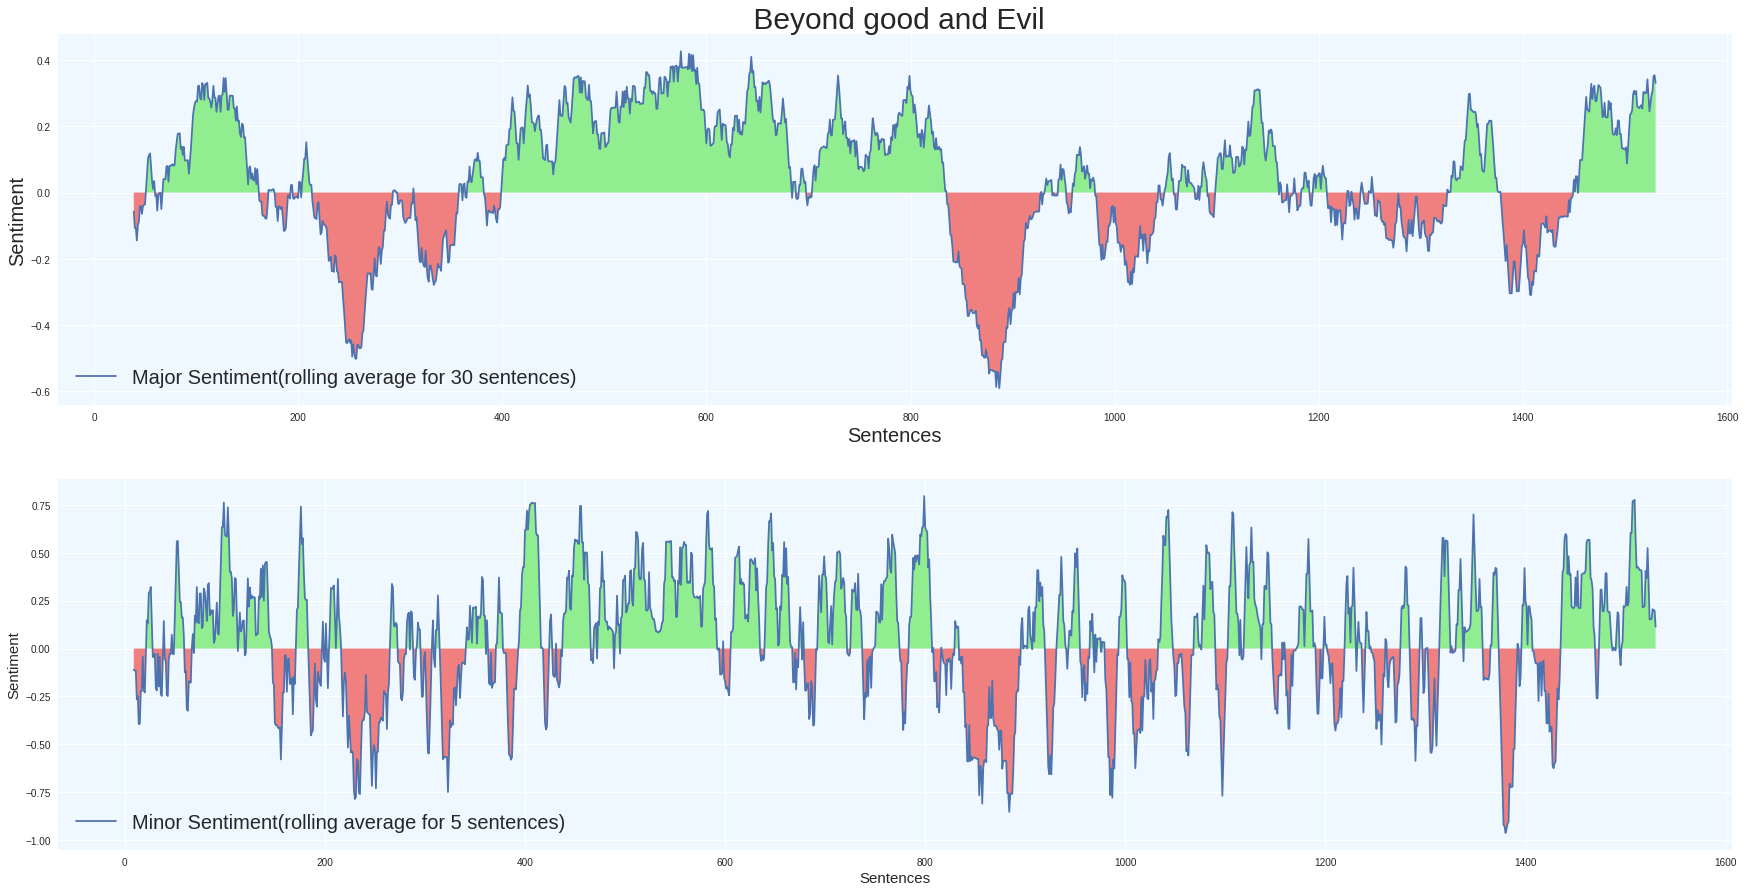

In [556]:
df = Analyzse_sentiment(sentences)
Display_sentiment(df , ' Beyond good and Evil')
df_emotions = Analyzse_Emotions(sentences)
Display_emotions(df_emotions)

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4
...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,ZWE,716
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,ZWE,716
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,ZWE,716
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,ZWE,716


In [705]:
import math
f = df_emotions.T
f['100'] =  (f.index/100).astype(int)
f['1'] = f.index
r = f.groupby(by=['100',0]).count()
r
d = pd.DataFrame(r)
d.reset_index(inplace=True)  
d


,100,0,1
0,0,anger,37
1,0,fear,4
2,0,joy,56
3,0,sadness,2
4,0,surprise,1
...,...,...,...
78,15,fear,1
79,15,joy,14
80,15,love,2
81,15,sadness,1


In [695]:
import plotly.io as pio
import plotly.express as px

pio.templates.default = "plotly_white"


fig = px.scatter(d,
                 x='100',y = 0 ,  size='1', color=0,
                 log_x=True,
                 title="Gapminder 2007: current default theme")
fig.show()

In [701]:
import plotly.io as pio
import plotly.express as px

pio.templates.default = "none"


fig = px.scatter(d,
                 x='100',y = 0 ,  size='1', color=0,
                 log_x=True,
                 title="Emotions per 100")
fig.show()

In [712]:
import plotly.express as px
fig = px.parallel_categories(d, color='1', color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

In [659]:
d = pd.DataFrame(r)
d.reset_index(inplace=True)  
d


,index,100,0,1,2
0,0,0,anger,37,"(0, anger)"
1,1,0,fear,4,"(0, fear)"
2,2,0,joy,56,"(0, joy)"
3,3,0,sadness,2,"(0, sadness)"
4,4,0,surprise,1,"(0, surprise)"
...,...,...,...,...,...
78,78,15,fear,1,"(15, fear)"
79,79,15,joy,14,"(15, joy)"
80,80,15,love,2,"(15, love)"
81,81,15,sadness,1,"(15, sadness)"
